# Tweet emotion Recognition

In [1]:
import pandas as pd  # Data analysis library
import pickle
import numpy as np
#import nlp
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

import re
import string

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

%matplotlib inline
fig_params = {
    'legend.fontsize': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.facecolor': '#D9DDD1'
}
plt.rcParams.update(fig_params)

In [2]:
#dataset=nlp.load_dataset('emotion')

In [3]:
#dataset

In [4]:
df = pd.read_pickle('./data/merged_training.pkl')

In [5]:
df.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416809 entries, 27383 to 64703
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      416809 non-null  object
 1   emotions  416809 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB


In [7]:
df['emotions'].unique()

array(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'],
      dtype=object)

<AxesSubplot:>

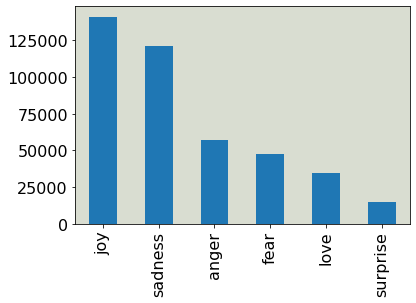

In [8]:
df['emotions'].value_counts().plot(kind='bar')

Let's create test,train and validation datasets from the above dataset.

In [9]:
X = df['text']
y = df['emotions']

In [10]:
tweet_tmp, tweet_ts, y_tmp, y_ts = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
tweet_tr, tweet_cv, y_tr, y_cv = train_test_split(tweet_tmp,
                                                  y_tmp,
                                                  test_size=0.25,
                                                  random_state=42)

In [11]:
df_train = pd.concat([tweet_tr, y_tr], axis=1)
df_val = pd.concat([tweet_cv, y_cv], axis=1)
df_test = pd.concat([tweet_ts, y_ts], axis=1)

In [35]:
df_val.shape

(83362, 3)

In [12]:
pickle.dump(df_train, open('./data/train.pkl', 'wb'))
pickle.dump(df_test, open('./data/test.pkl', 'wb'))
pickle.dump(df_val, open('./data/validation.pkl', 'wb'))

## Tokenization

In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(pattern='\n', repl=' ', string=text)
    text = re.sub(pattern='\t', repl=' ', string=text)
    text = re.sub('[0-9]', '', text)
    return text


def remove_stopwords_stemming(stemmer, text, need_stemming=True):
    if bool(need_stemming) == True:
        text_ret = [
            stemmer.stem(word.lower()) for word in text.split()
            if word.lower() not in stopwords.words('english')
        ]
    else:
        text_ret = [
            word.lower() for word in text.split()
            if word.lower() not in stopwords.words('english')
        ]
    return ' '.join(text_ret)


def stemming(stemmer, text):
    list = [stemmer.stem(word) for word in text.split()]
    return ' '.join(list)


def text_processing(text):
    text = clean_text(text)
    text = remove_stopwords_stemming(stemmer, text, need_stemming=True)
    #text=stemming(stemmer,text)
    return text

In [14]:
stemmer = SnowballStemmer(language='english')

In [15]:
df_train['processed'] = df_train['text'].apply(lambda x: text_processing(x))
df_val['processed'] = df_val['text'].apply(lambda x: text_processing(x))
df_test['processed'] = df_test['text'].apply(lambda x: text_processing(x))

In [16]:
df_test.describe()

,text,emotions,processed
count,83362,83362,83362
unique,82435,6,80872
top,i feel more adventurous willing to take risks ...,joy,feel accept
freq,3,28247,20


In [17]:
df_train['length_text'] = df_train['text'].apply(lambda x: len(x.split()))
df_train['length_processed'] = df_train['processed'].apply(
    lambda x: len(x.split()))

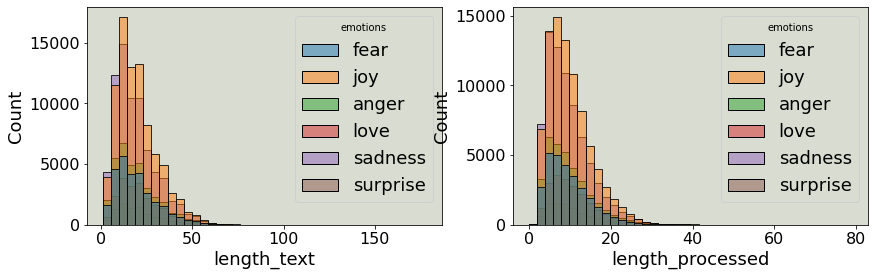

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.histplot(ax=ax[0], data=df_train, x='length_text', hue='emotions', bins=40)
sns.histplot(ax=ax[1],
             data=df_train,
             x='length_processed',
             hue='emotions',
             bins=40)
plt.show()

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/home/chaitanya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chaitanya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chaitanya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chaitanya/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

In [20]:
tokenizer = Tokenizer(num_words=12000, oov_token='<UKN>')
tokenizer.fit_on_texts(df_train['processed'])

In [21]:
def get_sequence(tokenizer, df, maxlen):
    sequence = tokenizer.texts_to_sequences(df)
    padded = pad_sequences(sequences=sequence,
                           maxlen=maxlen,
                           padding='post',
                           truncating='post')
    return padded

In [22]:
maxlen = 30
X_tr = np.array(get_sequence(tokenizer, df_train['processed'], maxlen))
X_cv = np.array(get_sequence(tokenizer, df_val['processed'], maxlen))
X_test = np.array(get_sequence(tokenizer, df_test['processed'], maxlen))

In [23]:
X_tr.shape

(250085, 30)

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
le = LabelEncoder()

In [26]:
le.fit(df_train['emotions'])

LabelEncoder()

In [27]:
y_tr = le.transform(df_train['emotions'])
y_cv = le.transform(df_val['emotions'])
y_test=le.transform(df_test['emotions'])

## Creating a model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout

In [29]:
model = Sequential()
model.add(Embedding(input_dim=12000, output_dim=20, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 20)            240000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               48400     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 289,006
Trainable params: 289,006
Non-trainable params: 0
_________________________________________________________________


In [36]:
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(250085, 30) (250085,)
(83362, 30) (83362,)
(83362, 30) (83362,)


In [37]:
model.fit(X_tr, y_tr, validation_data=(X_cv, y_cv), epochs=10, batch_size=64)

Train on 250085 samples, validate on 83362 samples
Epoch 1/10
250085/250085 [==============================] - 198s 792us/sample - loss: 0.1478 - acc: 0.9251 - val_loss: 0.1585 - val_acc: 0.9188
Epoch 2/10
250085/250085 [==============================] - 198s 790us/sample - loss: 0.1361 - acc: 0.9283 - val_loss: 0.1503 - val_acc: 0.9203
Epoch 3/10
250085/250085 [==============================] - 199s 797us/sample - loss: 0.1277 - acc: 0.9306 - val_loss: 0.1560 - val_acc: 0.9181
Epoch 4/10
250085/250085 [==============================] - 186s 743us/sample - loss: 0.1207 - acc: 0.9332 - val_loss: 0.1580 - val_acc: 0.9161
Epoch 5/10
250085/250085 [==============================] - 178s 710us/sample - loss: 0.1149 - acc: 0.9356 - val_loss: 0.1624 - val_acc: 0.9173
Epoch 6/10
250085/250085 [==============================] - 181s 722us/sample - loss: 0.1099 - acc: 0.9376 - val_loss: 0.1684 - val_acc: 0.9152
Epoch 7/10
250085/250085 [==============================] - 180s 721us/sample - loss:

<AxesSubplot:>

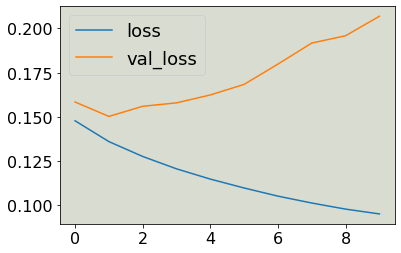

In [43]:
history = pd.DataFrame(model.history.history)
history[['loss','val_loss']].plot()

In [45]:
y_tr_pred = model.predict_classes(X_tr)
y_cv_pred = model.predict_classes(X_cv)

print('=' * 20)
print('training data \n', classification_report(y_tr, y_tr_pred))
print('=' * 20)
print('validation data \n',classification_report(y_cv, y_cv_pred))
print('=' * 20)

training data 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     34386
           1       0.91      0.93      0.92     28629
           2       0.98      0.95      0.96     84870
           3       0.82      0.94      0.88     20755
           4       0.97      0.99      0.98     72463
           5       0.86      0.81      0.83      8982

    accuracy                           0.95    250085
   macro avg       0.92      0.92      0.92    250085
weighted avg       0.95      0.95      0.95    250085

validation data 
               precision    recall  f1-score   support

           0       0.94      0.90      0.92     11592
           1       0.86      0.89      0.88      9707
           2       0.94      0.91      0.92     27950
           3       0.74      0.83      0.78      6946
           4       0.95      0.96      0.96     24220
           5       0.74      0.71      0.73      2947

    accuracy                           0.91

### RNN with dropout layers

In [46]:
model2 = Sequential()
model2.add(Embedding(input_dim=12000, output_dim=20, input_length=maxlen))
model2.add(Dropout(0.4))
model2.add(LSTM(100))
model2.add(Dropout(0.4))
model2.add(Dense(6, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [47]:
model2.fit(X_tr, y_tr, validation_data=(X_cv, y_cv), epochs=30, batch_size=64)

Train on 250085 samples, validate on 83362 samples
Epoch 1/30
250085/250085 [==============================] - 277s 1ms/sample - loss: 0.7511 - acc: 0.7105 - val_loss: 0.3597 - val_acc: 0.8749
Epoch 2/30
250085/250085 [==============================] - 254s 1ms/sample - loss: 0.3493 - acc: 0.8742 - val_loss: 0.2153 - val_acc: 0.9090
Epoch 3/30
250085/250085 [==============================] - 247s 989us/sample - loss: 0.2367 - acc: 0.9042 - val_loss: 0.1706 - val_acc: 0.9171
Epoch 4/30
250085/250085 [==============================] - 255s 1ms/sample - loss: 0.1988 - acc: 0.9119 - val_loss: 0.1585 - val_acc: 0.9189
Epoch 5/30
250085/250085 [==============================] - 295s 1ms/sample - loss: 0.1800 - acc: 0.9161 - val_loss: 0.1528 - val_acc: 0.9214
Epoch 6/30
250085/250085 [==============================] - 324s 1ms/sample - loss: 0.1708 - acc: 0.9188 - val_loss: 0.1485 - val_acc: 0.9211
Epoch 7/30
250085/250085 [==============================] - 243s 971us/sample - loss: 0.1611 - 

<AxesSubplot:>

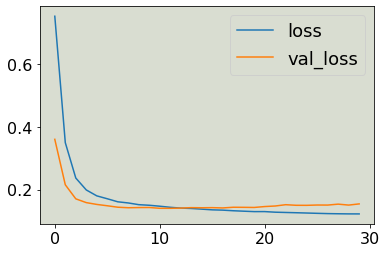

In [48]:
history = pd.DataFrame(model2.history.history)
history[['loss','val_loss']].plot()

In [49]:
y_tr_pred = model2.predict_classes(X_tr)
y_cv_pred = model2.predict_classes(X_cv)

print('=' * 20)
print('training data \n', classification_report(y_tr, y_tr_pred))
print('=' * 20)
print('validation data \n',classification_report(y_cv, y_cv_pred))
print('=' * 20)

training data 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     34386
           1       0.86      0.98      0.91     28629
           2       0.93      0.98      0.96     84870
           3       0.97      0.71      0.82     20755
           4       0.99      0.96      0.97     72463
           5       0.85      0.77      0.81      8982

    accuracy                           0.94    250085
   macro avg       0.93      0.89      0.90    250085
weighted avg       0.94      0.94      0.94    250085

validation data 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     11592
           1       0.84      0.96      0.90      9707
           2       0.91      0.96      0.94     27950
           3       0.90      0.65      0.76      6946
           4       0.98      0.95      0.96     24220
           5       0.80      0.74      0.77      2947

    accuracy                           0.92

### Biderectional lstm

In [50]:
model3 = Sequential()
model3.add(Embedding(input_dim=12000, output_dim=20, input_length=maxlen))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(100)))
model3.add(Dropout(0.4))
model3.add(Dense(6, activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [51]:
model3.fit(X_tr, y_tr, validation_data=(X_cv, y_cv), epochs=30, batch_size=64)

Train on 250085 samples, validate on 83362 samples
Epoch 1/30
250085/250085 [==============================] - 340s 1ms/sample - loss: 0.4211 - acc: 0.8380 - val_loss: 0.1799 - val_acc: 0.9147
Epoch 2/30
250085/250085 [==============================] - 382s 2ms/sample - loss: 0.1918 - acc: 0.9140 - val_loss: 0.1579 - val_acc: 0.9200
Epoch 3/30
250085/250085 [==============================] - 392s 2ms/sample - loss: 0.1684 - acc: 0.9194 - val_loss: 0.1528 - val_acc: 0.9201
Epoch 4/30
250085/250085 [==============================] - 401s 2ms/sample - loss: 0.1571 - acc: 0.9230 - val_loss: 0.1475 - val_acc: 0.9210
Epoch 5/30
250085/250085 [==============================] - 371s 1ms/sample - loss: 0.1480 - acc: 0.9246 - val_loss: 0.1437 - val_acc: 0.9213
Epoch 6/30
250085/250085 [==============================] - 364s 1ms/sample - loss: 0.1420 - acc: 0.9267 - val_loss: 0.1455 - val_acc: 0.9209
Epoch 7/30
250085/250085 [==============================] - 359s 1ms/sample - loss: 0.1369 - acc:

<AxesSubplot:>

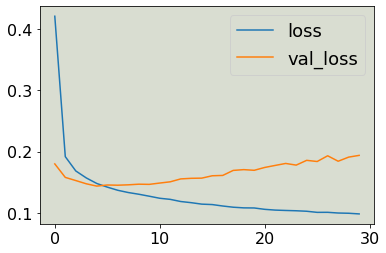

In [52]:
history = pd.DataFrame(model3.history.history)
history[['loss','val_loss']].plot()

In [53]:
y_tr_pred = model3.predict_classes(X_tr)
y_cv_pred = model3.predict_classes(X_cv)
print('=' * 20)
print('training data \n', classification_report(y_tr, y_tr_pred))
print('=' * 20)
print('validation data \n',classification_report(y_cv, y_cv_pred))
print('=' * 20)

training data 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     34386
           1       0.89      0.97      0.93     28629
           2       0.95      0.98      0.97     84870
           3       0.95      0.79      0.86     20755
           4       0.99      0.97      0.98     72463
           5       0.92      0.75      0.83      8982

    accuracy                           0.95    250085
   macro avg       0.94      0.91      0.92    250085
weighted avg       0.95      0.95      0.95    250085

validation data 
               precision    recall  f1-score   support

           0       0.92      0.93      0.92     11592
           1       0.84      0.91      0.88      9707
           2       0.91      0.95      0.93     27950
           3       0.82      0.69      0.75      6946
           4       0.97      0.94      0.96     24220
           5       0.81      0.67      0.73      2947

    accuracy                           0.91

Therefore, bidirectional LSTM with dropout layer works best on validation data

In [55]:
y_test_pred1 = model.predict_classes(X_test)
y_test_pred2 = model2.predict_classes(X_test)
y_test_pred3 = model3.predict_classes(X_test)

In [56]:
print('=' * 20)
print(classification_report(y_test, y_test_pred1))
print('=' * 20)
print(classification_report(y_test, y_test_pred2))
print('=' * 20)
print(classification_report(y_test, y_test_pred3))
print('=' * 20)


              precision    recall  f1-score   support

           0       0.93      0.90      0.92     11339
           1       0.86      0.89      0.88      9376
           2       0.94      0.91      0.93     28247
           3       0.74      0.83      0.78      6853
           4       0.95      0.96      0.96     24504
           5       0.78      0.73      0.75      3043

    accuracy                           0.91     83362
   macro avg       0.87      0.87      0.87     83362
weighted avg       0.91      0.91      0.91     83362

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     11339
           1       0.84      0.96      0.89      9376
           2       0.91      0.96      0.94     28247
           3       0.90      0.66      0.76      6853
           4       0.97      0.95      0.96     24504
           5       0.82      0.75      0.78      3043

    accuracy                           0.92     83362
   macro avg       0.89

It looks like unidirectional LSTM with dropout layers performs better on the validation as well as the test data compared to other two variants. 